## How does a neural net really work? 
Using some basic functions and shapes to visualize a 'gradient'. 

[Source](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work/comments)

In [1]:


#hide
from fastbook import *
from IPython.display import display,HTML
     


Fitting a function with gradient descent

A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1. Multiplies each input by a number of values. These values are known as parameters
2. Adds them up for each group of values
3. Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using gradient descent. Let's see how this works...



In [2]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

To learn how gradient descent works, we're going to start by fitting a quadratic.


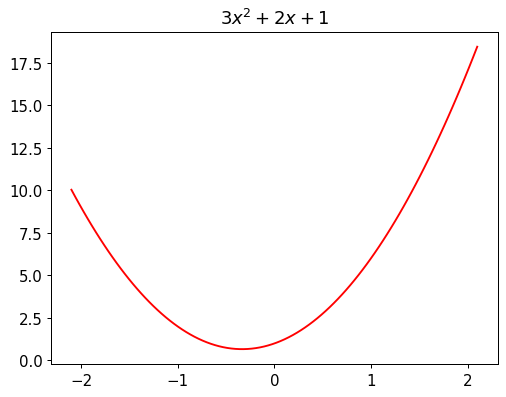

In [3]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

This quadratic is of the form $ax^2+bx+c$, with parameters $a=3$, $b=2$, $c=1$. To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

Create a quadratic function to which the values get passed. 

In [4]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [5]:
quad(3,2,1, 1.5)

10.75

Create a partial function to make the quad function easier to reuse. 

In [6]:
def make_quad(a,b,c): return partial(quad, a,b,c)

In [7]:
my_function = make_quad(3,2,1)
my_function(1.5)

10.75

Plot this partial function, same as before. 

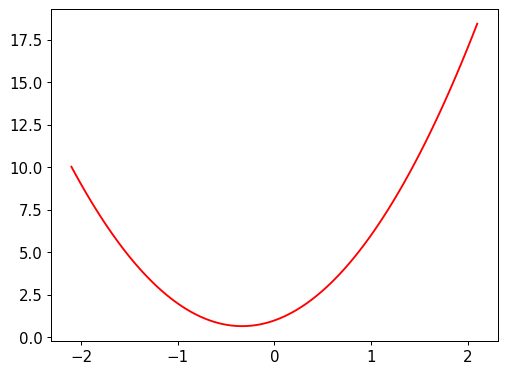

In [8]:
plot_function(my_function)

Prep work done above. The above functions will be used later on.  Now we start with some 'scattered' data and try to arrive at the above answer. 

In [9]:
np.random.seed(42)
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x*(1+noise(x,mult)) + noise(x,add)

In [10]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)


In [11]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

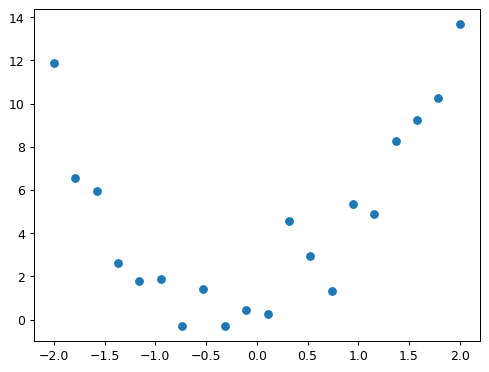

In [15]:
plt.scatter(x,y)

The goal is to find values of a,b,c which fit this data. One approach is to try a few values and see what fits. Here's a function which overlays a quadratic on top of our data, along with some sliders to change a, b, and c, and see how it looks:

In [14]:
@interact(a=1.1,b=1.1,c=1.1)
def plot_quad(a,b,c):
    plt.scatter(x,y)
    plot_function(make_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

One thing that's making this tricky is that we don't really have a great sense of whether our fit is really better or worse. It would be easier if we had a numeric measure of that. On easy metric we could use is mean absolute error -- which is the distance from each data point to the curve:

In [15]:
def mean_absolute_error(predictions, actuals): return (torch.abs(predictions-actuals)).mean()

In [17]:
@interact(a=1.1,b=1.1,c=1.1)
def plot_quad(a,b,c):
    my_function = make_quad(a,b,c)
    plt.scatter(x,y)
    loss = mean_absolute_error(my_function(x), y)
    plot_function(make_quad(a,b,c), ylim=(-3,13), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process.

Automating gradient descent. If we know the gradient of our mean_absolute_error() function with respect to our parameters, a, b, and c, then that means we know how adjusting (for instance) a will change the value of mean_absolute_error()

If, say, a has a negative gradient, then we know that increasing a will decrease mean_absolute_error(). Then we know that's what we need to do, since we trying to make mean_absolute_error() as low as possible.

So, we find the gradient of mean_absolute_error() for each of our parameters, and then adjust our parameters a bit in the opposite direction to the sign of the gradient.

To do this, first we need a function that takes all the parameters a, b, and c as a single vector input, and returns the value mean_absolute_error() based on those parameters:

In [18]:
def quad_mae(params):
    my_function = make_quad(*params) #argument expansion
    return mean_absolute_error(my_function(x), y)

In [19]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

Set up pytorch with a starting tensor, and give it the ability to calculate the gradient. 

We're first going to do exactly the same thing as we did manually -- pick some arbritrary starting point for our parameters. We'll put them all into a single tensor:

In [20]:
abc = torch.tensor([1.1,1.1,1.1])



To tell PyTorch that we want it to calculate gradients for these parameters, we need to call requires_grad_():


In [21]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)



We can now calculate mae(). Generally, when doing gradient descent, the thing we're trying to minimise is called the loss:


In [22]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

To get PyTorch to now calculate the gradients, we need to call backward()

In [23]:
loss.backward()



The gradients will be stored for us in an attribute called grad:


In [24]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit:

In [25]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
print(f'loss={loss:.2f}')

loss=2.40


Yes, our loss has gone down!

The "small number" we multiply is called the learning rate, and is the most important hyper-parameter to set when training a neural network.

BTW, you'll see we had to wrap our calculation of the new parameters in with torch.no_grad(). That disables the calculation of gradients for any operations inside that context manager. We have to do that, because abc -= abc.grad*0.01 isn't actually part of our quadratic model, so we don't want derivitives to include that calculation.

We can use a loop to do a few more iterations of this:

In [27]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=1.35
step=1; loss=1.22
step=2; loss=1.17
step=3; loss=1.17
step=4; loss=1.26
step=5; loss=1.40
step=6; loss=1.55
step=7; loss=1.70
step=8; loss=1.83
step=9; loss=1.95



As you can see, our loss keeps going down!

If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer! To avoid this, we need to decrease our learning rate as we train. This is done using a learning rate schedule, and can be automated in most deep learning frameworks, such as fastai and PyTorch.

How a neural network approximates any given function

But neural nets are much more convenient and powerful than this example showed, because we can learn much more than just a quadratic with them. How does that work?

The trick is that a neural network is a very expressive function. In fact -- it's infinitely expressive. A neural network can approximate any computable function, given enough parameters. A "computable function" can cover just about anything you can imagine: understand and translate human speech; paint a picture; diagnose a disease from medical imaging; write an essay; etc...

The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:

1. Matrix multiplication, which is just multiplying things together and then adding them up
2. The function max(x,0), which simply replaces all negative numbers with zero.

In PyTorch, the function max(x,0)
is written as np.clip(x,0). The combination of a linear function and this max() is called a rectified linear function, and it can be implemented like this:

In [28]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

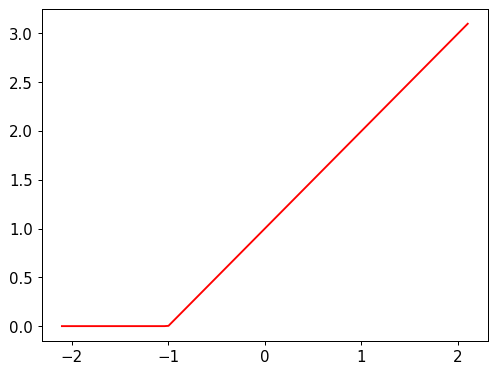

In [29]:
plot_function(partial(rectified_linear, 1,1))

instead of torch.clip(y, 0.), we can instead use F.relu(x), which does exactly the same thing. In PyTorch, F refers to the torch.nn.functional module.

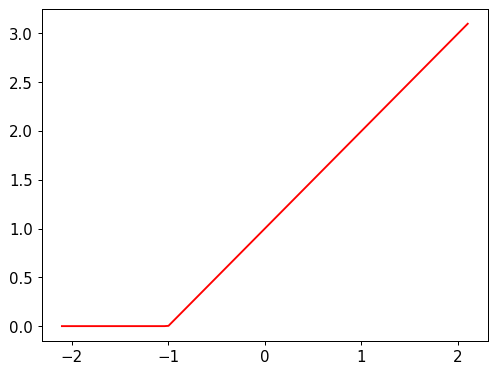

In [30]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))



To understand how this function works, try using this interactive version to play around with the parameters m and b:


In [31]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

As you see, m changes the slope, and b changes where the "hook" appears. This function doesn't do much on its own, but look what happens when we add two of them together:

In [32]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

If you play around with that for a while, you notice something quite profound: with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! Any time the function doesn't quite match, you can just add a few more additions to the mix to make it a bit closer. As an experiment, perhaps you'd like to try creating your own plot_triple_relu interactive function, and maybe even include the scatter plot of our data from before, to see how close you can get?

In [33]:
def triple_relu(m1,b1,m2,b2,m3,b3,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x) + rectified_linear(m3,b3,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=1.5, b3=1.5)
def plot_quad_triple_relu(m1, b1, m2, b2, m3, b3):
    my_function = partial(triple_relu, m1,b1,m2,b2,m3,b3)
    plt.scatter(x,y)
    loss = mean_absolute_error(my_function(x), y)
    plot_function(partial(triple_relu, m1,b1,m2,b2,m3,b3), ylim=(-3,13), title=f"MAE: {loss:.2f}")

# @interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=1.5, b3=1.5)
# def plot_triple_relu(m1, b1, m2, b2, m3, b3):
#     plot_function(partial(triple_relu, m1,b1,m2,b2,m3,b3), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

### Recap

Gradient descent is a method used in machine learning to find the minimum value of a function, such as a cost function used to evaluate the performance of a model. It works by iteratively adjusting the parameters of the function in small steps in the direction of steepest descent of the function's gradient until it reaches a minimum point. The goal is to find the values of the parameters that give the lowest possible cost, which indicates the best performance of the model.

Mean absolute error -- which is the distance from each data point to the curve. It's a way to measure how far apart a set of predicted values are from the actual values. It calculates the average absolute difference between the predicted values and the actual values.

